<a href="https://colab.research.google.com/github/Camouflage10/bloom-comp/blob/main/test_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install pycaret
!pip install pystac_client
!pip install planetary_computer
!pip install odc.stac

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 879.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.4/114.4 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.8 MB/s eta 0:00:00


In [ ]:
#imports
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
import pystac_client
import planetary_computer
import odc.stac
from pystac.extensions.eo import EOExtension as eo
from skimage.transform import resize

In [ ]:
metadata=pd.read_csv('metadata.csv')
train_y=pd.read_csv('train_labels.csv')
submission=pd.read_csv('submission_format.csv')
new = metadata["date"].str.split("-", expand = True)
metadata['year']=new[0].astype(int)
metadata['month']=new[1].astype(int)
metadata['day']=new[2].astype(int)
metadata

,uid,latitude,longitude,date,split,year,month,day
0,aabm,39.080319,-86.430867,2018-05-14,train,2018,5,14
1,aabn,36.559700,-121.510000,2016-08-31,test,2016,8,31
2,aacd,35.875083,-78.878434,2020-11-19,train,2020,11,19
3,aaee,35.487000,-79.062133,2016-08-24,train,2016,8,24
4,aaff,38.049471,-99.827001,2019-07-23,train,2019,7,23
...,...,...,...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test,2014,12,2
23566,zzwo,39.792190,-99.971050,2017-06-19,train,2017,6,19
23567,zzwq,35.794000,-79.012551,2015-03-24,train,2015,3,24
23568,zzyb,35.742000,-79.238600,2016-11-21,train,2016,11,21


In [ ]:
df=metadata.set_index('uid').join(train_y.set_index('uid'))
new = df["date"].str.split("-", expand = True)
df['year']=new[0].astype(int)
df['month']=new[1].astype(int)
df['day']=new[2].astype(int)
#add seasons based on month
df['season']=df['month']
df['season'].replace([1,11,12],value=4, inplace=True)
df['season'].replace([2,3,4],value=1, inplace=True)
df['season'].replace([5,6,7],value=2, inplace=True)
df['season'].replace([8,9,10], value=3, inplace=True)
df.reset_index(inplace=True)
df['region'].replace(['midwest', 'south', 'west', 'northeast'],
                        [0, 1, 2, 3], inplace=True)
submission['region'].replace(['midwest', 'south', 'west', 'northeast'],
                        [0, 1, 2, 3], inplace=True)

In [ ]:
def int_to_date(year,month, day):
  s=str(year)+'-'+str(month)+'-'+str(day)
  return s

int_to_date(2020,3,4)

'2020-3-4'

In [ ]:
def get_selected_item(time_of_interest, bbox_of_interest,cover):
  search = catalog.search(
      collections=["landsat-c2-l2","landsat-c2-l1"],
      bbox=bbox_of_interest,
      datetime=time_of_interest,
      query={"eo:cloud_cover": {"lt": cover}},
  )

  items = search.item_collection()
  #try catch start for not enough data or 
  selected_item = min(items, key=lambda item: eo.ext(item).cloud_cover)
  return selected_item

In [ ]:
def get_date(selected_item,bands_of_interest,bbox_of_interest):
  data = odc.stac.stac_load(
      [selected_item], bands=bands_of_interest, bbox=bbox_of_interest
  ).isel(time=0)
  return data


In [ ]:
def get_temp(selected_item,data):
  band_info = selected_item.assets["lwir11"].extra_fields["raster:bands"][0]
  temperature = data["lwir11"].astype(float)
  temperature *= band_info["scale"]
  temperature += band_info["offset"]
  celsius=temperature - 273.15
  return celsius

In [ ]:
def get_ndvi(data):
  red = data["red"].astype("float")
  nir = data["nir08"].astype("float")
  return (nir - red) / (nir + red)


In [ ]:
#put data into condensed images
size=32
offset=.005
cover=40
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
bands_of_interest = ["red","nir08"]


In [ ]:
#start looping
longs=35.875083
lat=-78.878434
year=2020
month=11
day=19
bbox_of_interest = [lat-offset, longs-offset, lat+offset, longs+offset]
#get date from a month of time and put in string format or month prior
time_of_interest=int_to_date(year,month,day)+"/"+int_to_date(year,month+1,1)
time_of_interest

'2020-11-19/2020-12-1'

In [ ]:
def get_stemp(bands_of_interest,bbox_of_interest,time_of_interest,size,cover):
  try:
    selected_item=get_selected_item(time_of_interest, bbox_of_interest,cover)
    data=get_date(selected_item,bands_of_interest,bbox_of_interest)
    celsius=get_temp(selected_item,data)
    return resize(celsius, (size, size), anti_aliasing=True)
  except:
    return None

i=get_stemp(bands_of_interest,bbox_of_interest,time_of_interest,size,cover)

In [ ]:
def get_sndvi(bands_of_interest,bbox_of_interest,time_of_interest,size,cover):
  try:
    selected_item=get_selected_item(time_of_interest, bbox_of_interest,cover)
    data=get_date(selected_item,bands_of_interest,bbox_of_interest)
    ndvi=get_ndvi(data)
    return resize(ndvi, (size, size), anti_aliasing=True)
  except:
    return None

i=get_sndvi(bands_of_interest,bbox_of_interest,time_of_interest,size,cover)

23570


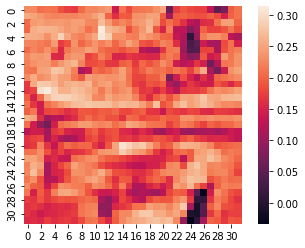

In [ ]:
print(len(df))
sn.heatmap(i, square=True)

In [ ]:
def add_months_stemp(i,longs,lat,year,month,day):
  print(i)
  limit=5
  add=1
  if month+add>12:
    time_of_interest=int_to_date(year,month,day)+"/"+int_to_date(year+1,month+add,1)
  else:
    time_of_interest=int_to_date(year,month,day)+"/"+int_to_date(year,month+add,1)
  bbox_of_interest = [longs-offset, lat-offset, longs+offset, lat+offset]
  return get_stemp(bands_of_interest,bbox_of_interest,time_of_interest,size,cover)
    

In [ ]:
def add_months_sndvi(i,longs,lat,year,month,day):
  print(i)
  limit=5
  add=1
  if month+add>12:
    time_of_interest=int_to_date(year,month,day)+"/"+int_to_date(year+1,month+add,1)
  else:
    time_of_interest=int_to_date(year,month,day)+"/"+int_to_date(year,month+add,1)
  bbox_of_interest = [longs-offset, lat-offset, longs+offset, lat+offset]
  return get_sndvi(bands_of_interest,bbox_of_interest,time_of_interest,size,cover)

In [ ]:
#turn into a loop that goes thru each 200 and saves into images with names being the uid in a directory then add a check if the first file already exsists before starting 
import time
import concurrent
s=time.perf_counter()
r=[]
df_2=pd.DataFrame(df, columns = [ 'longitude', 'latitude','year', 'month', 'day'])
df_3=df_2.head(100)
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executer:
  y=range(len(df_3))
  r=zip(y, executer.map(add_months_sndvi,y,df_3['longitude'],df_3['latitude'],df_3['year'],df_3['month'],df_3['day']))
f=time.perf_counter()
print('threaded time=',f-s)

0
1
23

4
5
6
78

9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
4849

50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
threaded time= 74.2450267050001


In [ ]:
results=list(r)
c=0
for i,j in results:
  if j is not None:
    c+=1
c/len(results)

0.97